<br>

#### Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle

<br>

#### Reading in Data

In [2]:
df_EI = pd.read_csv('data/EI.csv', parse_dates=['local_datetime'])
df_EI['local_datetime'] = pd.DatetimeIndex(pd.to_datetime(df_EI['local_datetime'], utc=True)).tz_convert('Europe/London')
df_EI = df_EI.set_index('local_datetime')
df_EI.head()

,SP,TCO2_per_h,belgian,biomass,coal,day_ahead_price,demand,dutch,french,gCO2_per_kWh,...,irish,northern_ireland,nuclear,pumped_storage,solar,temperature,valueSum,wind,windOffshore,windOnshore
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,1,21278.0,0.0,0.0,17.650,58.05,38.329,0.0,1.977,555.0,...,-0.161,0.0,6.973,-0.404,0.0,-0.6,NaN,0.148,NaN,NaN
2009-01-01 00:30:00+00:00,2,21442.0,0.0,0.0,17.770,56.33,38.461,0.0,1.977,558.0,...,-0.160,0.0,6.968,-0.527,0.0,-0.6,NaN,0.157,NaN,NaN
2009-01-01 01:00:00+00:00,3,21614.0,0.0,0.0,18.070,52.98,37.986,0.0,1.977,569.0,...,-0.160,0.0,6.970,-1.018,0.0,-0.6,NaN,0.147,NaN,NaN
2009-01-01 01:30:00+00:00,4,21320.0,0.0,0.0,18.022,50.39,36.864,0.0,1.746,578.0,...,-0.160,0.0,6.969,-1.269,0.0,-0.6,NaN,0.148,NaN,NaN
2009-01-01 02:00:00+00:00,5,21160.0,0.0,0.0,17.998,48.70,36.180,0.0,1.730,585.0,...,-0.160,0.0,6.960,-1.566,0.0,-0.6,NaN,0.160,NaN,NaN


<br>

#### Constructing Heatmap

In [3]:
def create_fuel_pct(df_EI, fuel, demand_col='demand'):
    s_fuel_pct = 100*df_EI[fuel]/df_EI[demand_col]
    
    df_fuel_pct = pd.DataFrame({f'{fuel}_pct':s_fuel_pct})
    
    return df_fuel_pct

df_coal_pct = create_fuel_pct(df_EI, 'coal')
df_coal_pct.head()

,coal_pct
local_datetime,
2009-01-01 00:00:00+00:00,46.048684
2009-01-01 00:30:00+00:00,46.202647
2009-01-01 01:00:00+00:00,47.570157
2009-01-01 01:30:00+00:00,48.887804
2009-01-01 02:00:00+00:00,49.745716


In [4]:
df_fuel_pct = df_coal_pct.resample('D').mean()
df_fuel_pct['year'] = df_fuel_pct.index.year.astype(str)

pd.DatetimeIndex(df_fuel_pct['year'] + '-01-01')

DatetimeIndex(['2009-01-01', '2009-01-01', '2009-01-01', '2009-01-01',
               '2009-01-01', '2009-01-01', '2009-01-01', '2009-01-01',
               '2009-01-01', '2009-01-01',
               ...
               '2019-01-01', '2019-01-01', '2019-01-01', '2019-01-01',
               '2019-01-01', '2019-01-01', '2019-01-01', '2019-01-01',
               '2019-01-01', '2019-01-01'],
              dtype='datetime64[ns]', name='year', length=3925, freq=None)

In [5]:
def df_fuel_pct_2_wide(df_fuel_pct, fuel, shift_NaNs=False):
    df_fuel_pct['year'] = df_fuel_pct.index.year.astype(str)
    df_fuel_pct['seconds'] = (df_fuel_pct.index - pd.DatetimeIndex(df_fuel_pct['year'] + '-01-01', tz='UTC').tz_convert('Europe/London')).total_seconds().astype(int)
    df_fuel_pct['doy'] = df_fuel_pct.index.dayofyear

    df_fuel_pct_wide = df_fuel_pct.pivot(index='year', columns='doy', values=f'{fuel}_pct')
    
    if shift_NaNs == True:
        df_fuel_pct_wide = df_fuel_pct_wide.apply(lambda x: pd.Series(x.dropna().values), axis=1)
    
    return df_fuel_pct_wide

df_coal_wide = df_fuel_pct_2_wide(df_coal_pct.resample('D').mean(), 'coal')
df_coal_wide.head()

doy,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2009,46.780983,47.201978,45.552625,44.351383,46.371201,48.761557,48.940804,49.544196,50.383032,47.705824,...,37.928446,30.051602,22.402288,22.782755,22.483314,29.134621,30.132558,27.785349,NaN,NaN
2010,25.408225,28.327094,28.249597,41.858468,44.016905,44.680811,45.825646,46.610729,42.505161,46.256552,...,41.316051,41.385988,40.554070,38.342819,38.567708,37.873314,43.099999,42.707975,NaN,NaN
2011,35.948045,37.054707,43.288379,41.714301,39.184584,38.057516,38.258649,32.439328,30.698827,36.124075,...,38.684768,31.554128,31.402088,28.400912,35.280480,39.794171,39.823474,38.672004,NaN,NaN
2012,25.654850,28.527751,36.594391,39.460064,38.860765,39.531993,32.888722,35.611951,40.862707,42.490876,...,47.851389,46.470533,50.328894,47.663995,44.240725,44.323820,42.896427,36.013889,37.337049,NaN
2013,41.623051,42.583045,43.147382,43.129800,43.568816,41.966203,45.798026,46.317263,47.326194,47.321756,...,35.659472,35.657523,38.630559,42.171730,35.417013,38.021075,38.888842,35.447327,NaN,NaN


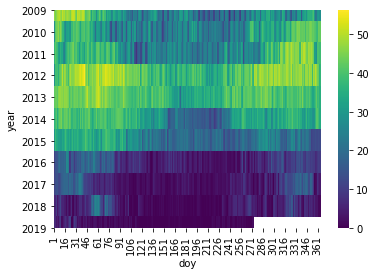

In [6]:
sns.heatmap(df_coal_wide, cmap='viridis')

<br>

#### Repeating Across Fuels

In order to nicely format the x axis we'll need to determine when each month starts and assign it a label

In [7]:
def create_month_starts_names():
    s_doy = pd.Series(index=pd.date_range('2018', '2019', freq='30T')).resample('D').mean()
    s_doy.loc[:] = s_doy.index.dayofyear

    month_starts = s_doy.groupby(s_doy.index.month).min() + 15
    month_names = s_doy.index.month_name().unique()

    return month_starts, month_names

month_starts, month_names = create_month_starts_names()
dict(zip(month_names, month_starts))

{'January': 16,
 'February': 47,
 'March': 75,
 'April': 106,
 'May': 136,
 'June': 167,
 'July': 197,
 'August': 228,
 'September': 259,
 'October': 289,
 'November': 320,
 'December': 350}

In [8]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
rgb_2_color = lambda rgb_list: [elem/255 for elem in rgb_list]

fuel_cmaps = {
     'coal' : [rgb_2_color([0, 204, 68]), rgb_2_color([0, 204, 68]), 0.0001, c('white'), c('black')],
     'gas' : [c('white'), c('lightcoral')],
     'solar' : [c('white'), c('gold')],
     'solar_multi' : [c('black'), c('midnightblue'), 0.33, c('midnightblue'), c('gold'), 0.66, c('gold'), c('yellow')],
     'wind' : [c('white'), c('lightseagreen')],
     'biomass' : [c('white'), c('brown')],
 }

<Figure size 432x288 with 0 Axes>

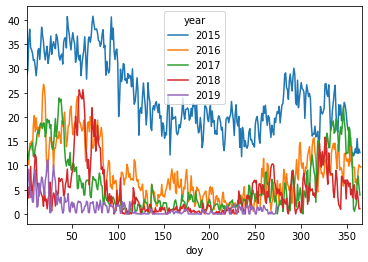

In [9]:
df_fuel_pct = create_fuel_pct(df_EI, 'coal')
df_fuel_wide = df_fuel_pct_2_wide(df_fuel_pct.resample('D').mean(), 'coal')

plt.figure()
df_fuel_wide['2015':].T.plot()

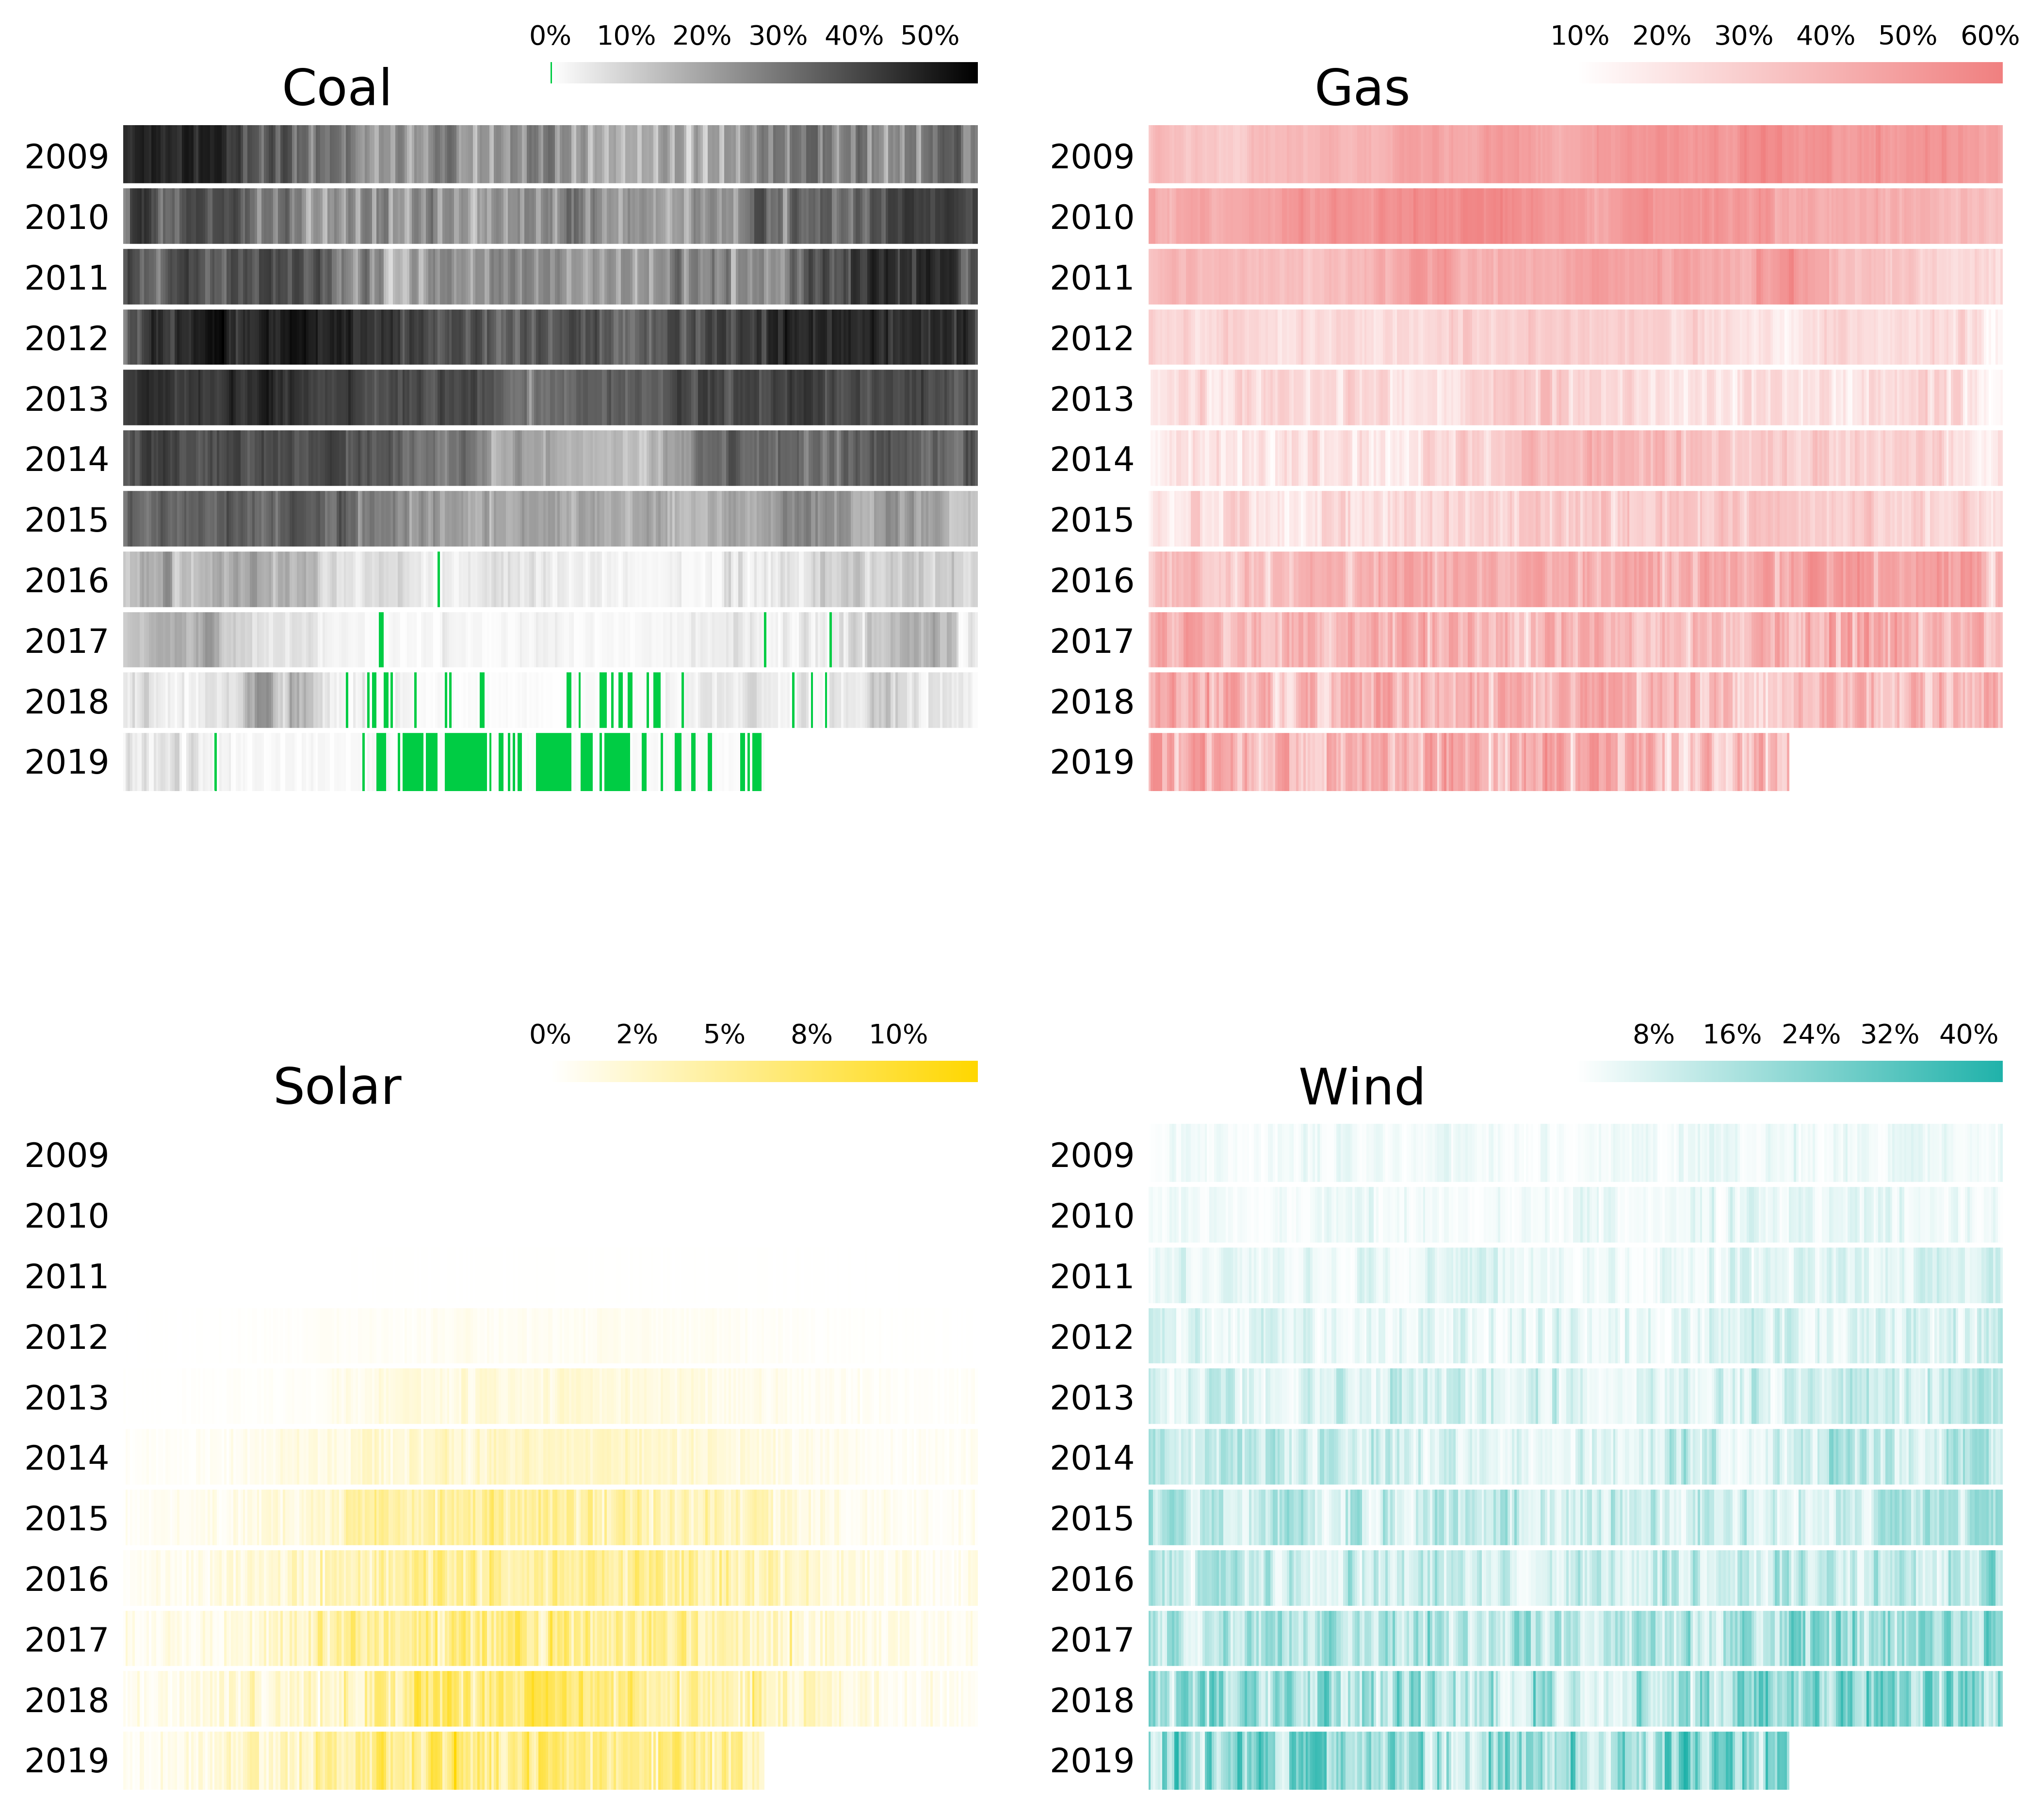

In [12]:
def plot_wide_fuel(df_fuel_wide, fuel, ax, bkg_c='white', cmap='viridis'):
    ## Creating heatmap
    sns.heatmap(df_fuel_wide, cmap=cmap, ax=ax, mask=df_fuel_wide.isnull(),
                cbar_kws={'use_gridspec':False, 'shrink':0.5, 'location':'top', 
                          'anchor':(1, 0), 'format':'%.0f%%'})
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8, top=False, pad=0.05)
            
    ## Setting main and axis titles
    ax.set_title(f"{fuel.replace('_', ' ').title()}", y=1.05, x=0.25, size=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(df_fuel_wide.shape[0], 0)
    
    ## Formatting ticks
    month_starts, month_names = create_month_starts_names()
    ax.set_yticklabels(list(range(2009,2019+1)), fontsize=10)

    ax.hlines(list(range(1, 11)), xmin=0, xmax=365, color=[bkg_c])
    ax.tick_params(left=False, bottom=False, labelbottom=False, pad=0.5)
        
    return ax

fuels = ['coal', 'gas', 'solar', 'wind']
bkg_c = 'white'
ax = dict()

fig = plt.figure(figsize=(10, 10), facecolor=bkg_c, dpi=500)
for i, fuel in enumerate(fuels):
    ax[fuel] = plt.subplot(2, 2, i+1)

for fuel in fuels:
    ## Creating wide df for fuel
    df_fuel_pct = create_fuel_pct(df_EI, fuel)
    df_fuel_wide = df_fuel_pct_2_wide(df_fuel_pct.resample('D').mean(), fuel)
    
    ## Removing extra days caused by leap years
    cols_2_drop = list(df_fuel_wide.columns[df_fuel_wide.isnull().sum()>1])
    df_fuel_wide = df_fuel_wide.drop(columns=cols_2_drop)
    
    ## Plotting    
    ax[fuel] = plot_wide_fuel(df_fuel_wide, fuel, ax[fuel], bkg_c, cmap=make_colormap(fuel_cmaps[fuel]))
 
#fig.savefig('img/fuel_pct.png')

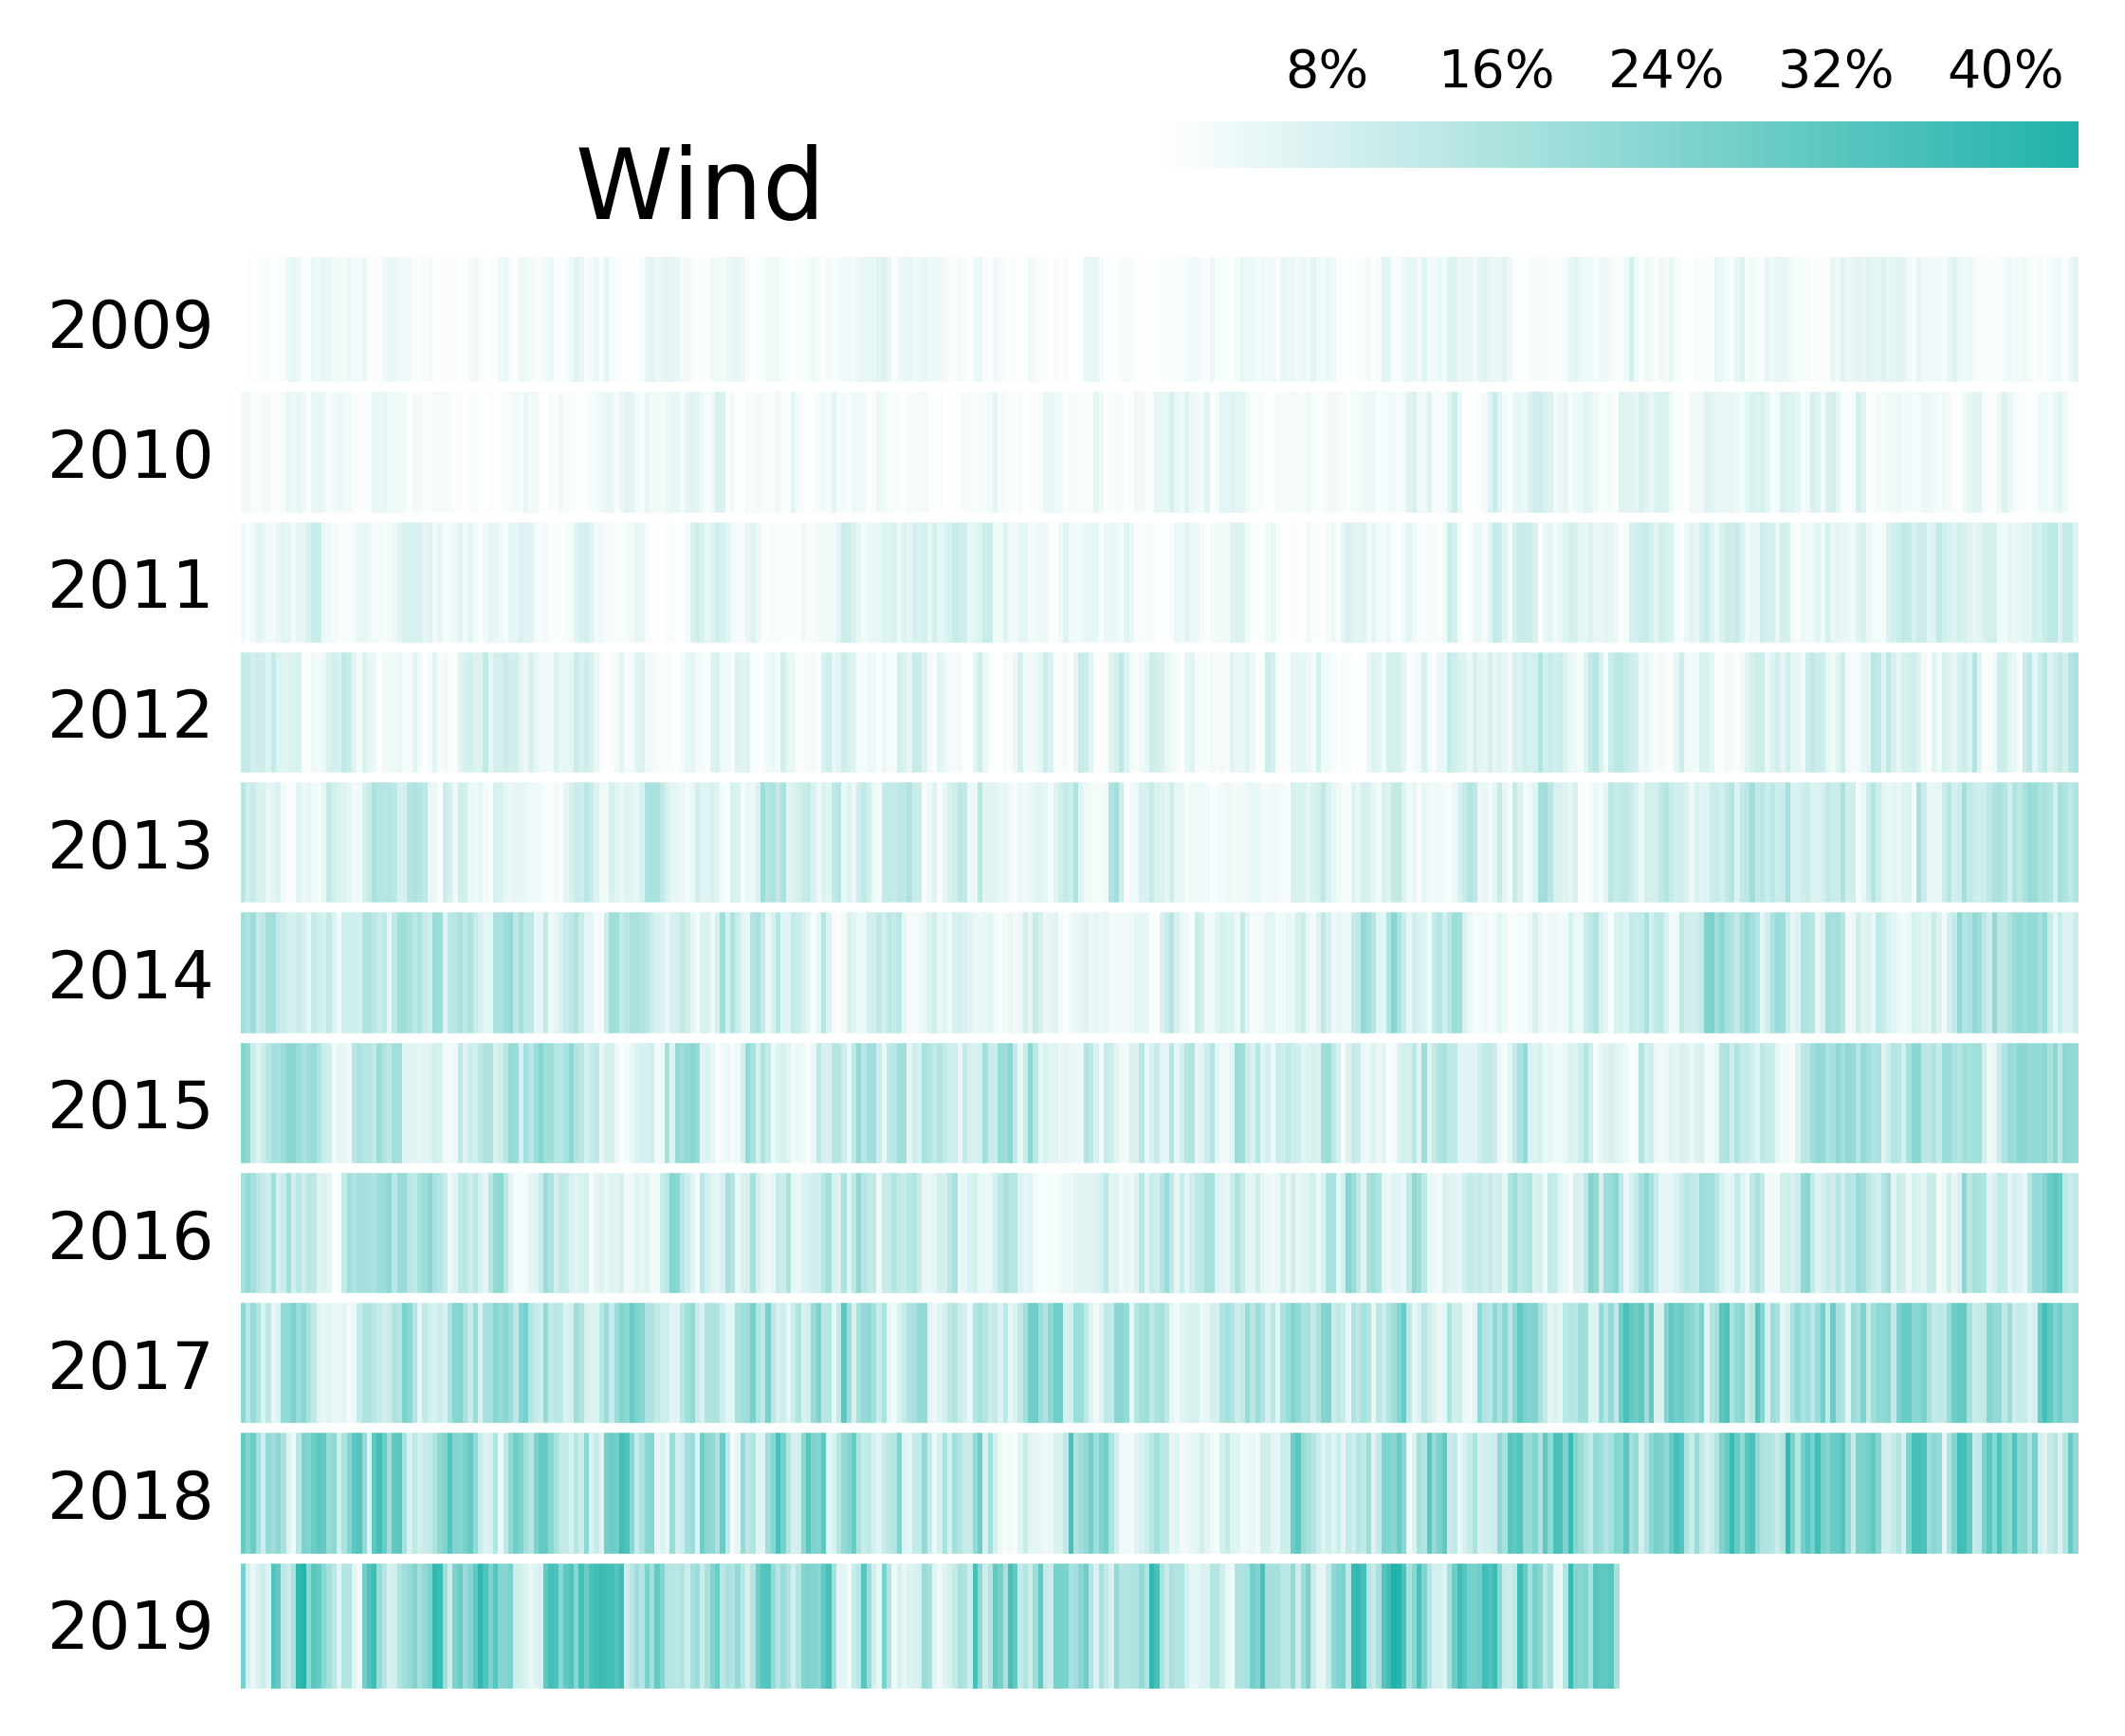

In [13]:
fig = plt.figure(dpi=500, figsize=(5, 5))
ax = plt.subplot()

for fuel in ['wind']:
    ## Creating wide df for fuel
    df_fuel_pct = create_fuel_pct(df_EI, fuel)
    df_fuel_wide = df_fuel_pct_2_wide(df_fuel_pct.resample('D').mean(), fuel)
    
    ## Removing extra days caused by leap years
    cols_2_drop = list(df_fuel_wide.columns[df_fuel_wide.isnull().sum()>1])
    df_fuel_wide = df_fuel_wide.drop(columns=cols_2_drop)
    
    ## Plotting    
    ax = plot_wide_fuel(df_fuel_wide, fuel, ax, bkg_c, cmap=make_colormap(fuel_cmaps[fuel]))
    
fig.savefig('img/wind.png')